In [3]:
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline
import os
from os.path import join

import keras
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Conv2D, Input, Reshape, concatenate, MaxPooling2D,Dropout, Flatten, 
RepeatVector, UpSampling2D, Conv1D, Permute, BatchNormalization, Activation, UpSampling2D)
from keras import Model
from keras.engine.topology import Layer, InputSpec
from keras import backend as K
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.losses import mean_squared_error
from keras.preprocessing import sequence

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Hydra Autoencoder

Model that understands our synthetic datasets (android, ios, web) interfaces, using a shared CNN to encode each picture, and unique heads to decode for each platform (3 heads)

In [4]:
def load_guis(data_dir):
    """Loads in target data (picture data) in a given directory.
    Returns a np.array of the data loaded."""
    GUIS = []
    training_GUI_listing = os.listdir(data_dir)
    for listing in training_GUI_listing:
        if listing.endswith('.npz'):
            temp = np.load(join(data_dir, listing))['features']
            # reshape to be flat
            GUIS += [temp]
    GUIS = np.array(GUIS)
    return GUIS

def make_head():
    """Returns a standard decoder model"""
    input_layer = Input(shape=(16, 16, 16))
    last = Conv2D(128, (4, 4), padding='same', activation='relu')(input_layer)

    last = BatchNormalization()(last)
    last = UpSampling2D(size=(2, 2))(last)
    last = Conv2D(96, (3, 3), padding='same', activation='relu')(last)
    # model.add(Conv2DTranspose(96, (2, 2), strides=(2, 2)))
    last = BatchNormalization()(last)
    last = UpSampling2D(size=(4, 4))(last)
    last = Conv2D(32, (3, 3), padding='same', activation='relu')(last)
    # model.add(Conv2DTranspose(32, (2, 2), strides=(2, 2)))
    last = BatchNormalization()(last)
    last = UpSampling2D(size=(2, 2))(last)
    # model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    last = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(last)
    # model.add(Conv2DTranspose(color, (3, 3), strides=(2, 2)))
    model = Model(input_layer, last)
    return model
    
def make_hydra(loss='binary_crossentropy', optimizer='rmsprop'):
    """Creates 3 headed autoencoder model to handle the different datasets.
    Returns [android, ios, web] models"""
    keras.backend.clear_session()

    input_layer = Input(shape=(256, 256, 3))
    drop_rate = 0.25
    last = Conv2D(64, (5, 5), strides=(2,2), activation='relu')(input_layer)
    last = Conv2D(128, (4, 4), padding='same', strides=(1,1), activation='relu')(last)
    last = MaxPooling2D(pool_size=(2,2))(last)
    last = Dropout(drop_rate)(last)
    last = Conv2D(128, (4, 4), padding='same', strides=(2,2), activation='relu')(last)
    last = Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = MaxPooling2D(pool_size=(2, 2))(last)
    last = Dropout(drop_rate)(last)

    last = Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu')(last)

    encoder = Model(input_layer, last)
    android = make_head()
    ios = make_head()
    web = make_head()
    
    models = []
    for model in [android, ios, web]:
        head_spout = model(encoder.output)
        head = Model(input_layer, head_spout)
        head.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        models.append(head)
    return models

def train_hydra(epochs, models, datasets):
    """Assumes models=[android, ios, web], and datasets ordered alphabetically as well.
    Trains the models sequentially, 1 epoch after the other. 
    ~16 epochs seems to give good perf, >30 pretty good"""
    for i in range(epochs):
        print("Epoch: {}".format(i+1))
        for model, data in zip(models, datasets):
            model.fit(data, data, batch_size=16, validation_split=0.2)
            
android_data = load_guis('android/training_features/')
ios_data = load_guis('ios/training_features/')
web_data = load_guis('web/training_features/')
models = make_hydra()
train_hydra(25, models, [android_data, ios_data, web_data])

Epoch: 1
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 13s 11ms/step - loss: 0.4842 - acc: 0.0047 - val_loss: 0.5473 - val_acc: 0.0059
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.5425 - acc: 0.4578 - val_loss: 0.2402 - val_acc: 0.5003
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.5354 - acc: 0.3146 - val_loss: 0.2657 - val_acc: 0.3678
Epoch: 2
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 11s 10ms/step - loss: 0.2425 - acc: 0.0051 - val_loss: 0.5431 - val_acc: 0.0065
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 11s 9ms/step - loss: 0.2139 - acc: 0.5194 - val_loss: 0.2061 - val_acc: 0.5012
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [=====

1200/1200 [==============================] - 12s 10ms/step - loss: 0.1405 - acc: 0.3655 - val_loss: 0.1446 - val_acc: 0.3816
Epoch: 16
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.1847 - acc: 0.0069 - val_loss: 0.1858 - val_acc: 0.0069
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.1458 - acc: 0.5196 - val_loss: 0.1526 - val_acc: 0.5018
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.1401 - acc: 0.3656 - val_loss: 0.1445 - val_acc: 0.3814
Epoch: 17
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.1844 - acc: 0.0069 - val_loss: 0.1841 - val_acc: 0.0070
Train on 1200 samples, validate on 300 samples
Epoch 1/1
1200/1200 [==============================] - 12s 10ms/step - loss: 0.1

TypeError: save() missing 1 required positional argument: 'filepath'

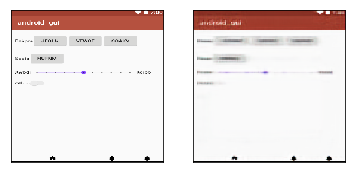

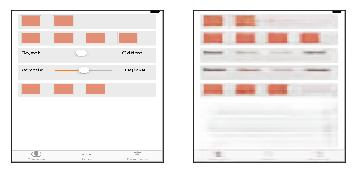

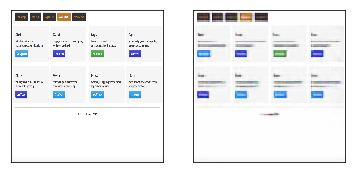

In [8]:
def predict(model, dataset, idx, name):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(dataset[idx])
    axes[1].imshow(model.predict(np.expand_dims(dataset[idx], 0))[0])
    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])
        
    fig.savefig(name, dpi=70)
    plt.show()

for model, data, name in zip(models, [android_data, ios_data, web_data], ['android', 'ios', 'web']):
    predict(model, data, 100, '{}_hydra.png'.format(name))
    model.save('{}-hydra-model'.format(name))

In [10]:
% ls *-model

android-hydra-model  ios-hydra-model  web-hydra-model
